In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# Установим нужные библиотеки
!pip install torch torchvision matplotlib scikit-learn pandas seaborn

# Импортируем библиотеки
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Torch и torchvision
import torch
from torch import nn
from torchvision import models, transforms



In [13]:
# Параметры данных
data_dir = "/content/drive/MyDrive/IBCh/LIveMIELmiiish2/single_nuclei_images/19_10_2024AIRE1_sorting"  # Замените на путь к вашим папкам
days = ["0 day", "1 day", "4 day"]  # Папки с изображениями
image_size = (224, 224)  # Размеры изображений для обработки нейросетью

# Трансформации изображений
transform = transforms.Compose([
  transforms.Resize(image_size),  # Изменение размера
  transforms.ToTensor(),  # Преобразование в тензор
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация
])

# Загрузка изображений и создание меток
def load_images_and_labels(data_dir, days, transform):
  images = []
  labels = []
  for label, day in enumerate(days):  # label будет соответствовать 0, 1, 2
    folder_path = os.path.join(data_dir, day)  # Путь к папке текущего дня
    if not os.path.exists(folder_path):  # Проверка на существование папки
      print(f"Папка {folder_path} не найдена, пропускаем.")
      continue
    for file_name in os.listdir(folder_path):
      file_path = os.path.join(folder_path, file_name)  # Полный путь к изображению
      try:
        image = Image.open(file_path).convert("RGB")  # Открываем изображение
        image = transform(image)  # Применяем трансформации
        images.append(image)  # Добавляем преобразованное изображение
        labels.append(label)  # Добавляем метку
      except Exception as e:
        print(f"Ошибка с файлом {file_path}: {e}")  # Лог ошибок
  if len(images) == 0:
    raise RuntimeError("Не удалось загрузить изображения. Проверьте пути к данным.")
  return torch.stack(images), np.array(labels)

# Загрузка изображений и меток
images, labels = load_images_and_labels(data_dir, days, transform)
print(f"Загружено {len(images)} изображений.")
print(f"Форма тензора изображений: {images.shape}")
print(f"Метки: {np.unique(labels, return_counts=True)}")


Загружено 989 изображений.
Форма тензора изображений: torch.Size([989, 3, 224, 224])
Метки: (array([0, 1, 2]), array([187, 454, 348]))


In [14]:
# Загружаем предобученную модель (например, EfficientNet)
model = models.efficientnet_b0(pretrained=True)  # Используем EfficientNet с предобученными весами
feature_extractor = nn.Sequential(*(list(model.children())[:-1]))  # Удаляем последний классификатор
feature_extractor.eval()  # Переключаем в режим оценки (inference)

# Функция для извлечения признаков
def extract_features(images, model, batch_size=32):
  """
  Извлечение признаков из изображений.

  images: torch.Tensor - Тензор изображений (N, C, H, W).
  model: nn.Module - Нейросеть для извлечения признаков.
  batch_size: int - Размер батча для обработки.
  """
  features = []  # Для хранения признаков
  model = model.to('cuda' if torch.cuda.is_available() else 'cpu')  # Перенос модели на GPU или CPU
  images = images.to('cuda' if torch.cuda.is_available() else 'cpu')  # Перенос изображений

  with torch.no_grad():  # Отключаем градиенты
    for i in range(0, len(images), batch_size):  # Батчевый процессинг
      batch = images[i:i + batch_size]  # Текущий батч
      batch_features = model(batch).squeeze()  # Извлекаем признаки
      features.append(batch_features.cpu().numpy())  # Переносим на CPU и добавляем в список

  return np.concatenate(features, axis=0)  # Объединяем все батчи в один массив

# Извлекаем признаки для всех изображений
features = extract_features(images, feature_extractor)
print(f"Извлечено признаков: {features.shape}")  # Выводим размер извлеченных признаков


Извлечено признаков: (989, 1280)


In [15]:
features

array([[-0.18744433, -0.02664218, -0.06792857, ..., -0.12466539,
        -0.18689504, -0.1649538 ],
       [-0.20498672, -0.06005325, -0.17930423, ..., -0.10663404,
        -0.12063726, -0.12275663],
       [-0.16140448, -0.0341061 , -0.08741084, ..., -0.17446077,
        -0.16213861, -0.1730178 ],
       ...,
       [-0.14708348, -0.04349876, -0.0778418 , ..., -0.22687818,
        -0.1148265 , -0.12106241],
       [-0.17401029, -0.07315186, -0.09979785, ..., -0.24085185,
        -0.06639854,  0.47177187],
       [-0.0868125 , -0.07630724, -0.08255595, ..., -0.01159462,
        -0.11547388,  0.52559894]], dtype=float32)

PCA завершено. Объяснённая дисперсия: 0.42
Размеры после PCA: (989, 2)


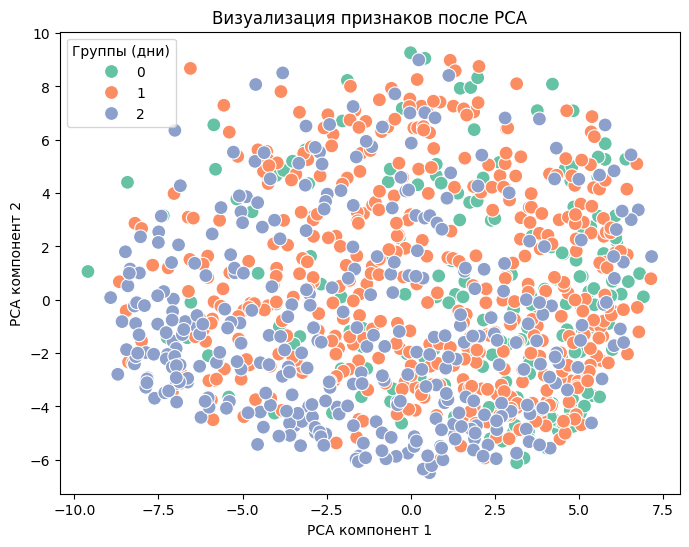

In [16]:
# Анализ с использованием PCA
def apply_pca(features, n_components=2):
  """
  Применение PCA к извлечённым признакам.

  features: np.ndarray - Матрица признаков (N, D), где N - число изображений, D - число признаков.
  n_components: int - Число компонентов для PCA.

  return: np.ndarray - Преобразованные признаки (N, n_components).
  """
  pca = PCA(n_components=n_components)  # Инициализация PCA
  reduced_features = pca.fit_transform(features)  # Применяем PCA к признакам
  explained_variance = np.sum(pca.explained_variance_ratio_)  # Объяснённая дисперсия
  print(f"PCA завершено. Объяснённая дисперсия: {explained_variance:.2f}")
  return reduced_features

# Применяем PCA
reduced_features = apply_pca(features)
print(f"Размеры после PCA: {reduced_features.shape}")

# Визуализация результатов PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=labels, palette="Set2", s=100)
plt.title("Визуализация признаков после PCA")
plt.xlabel("PCA компонент 1")
plt.ylabel("PCA компонент 2")
plt.legend(title="Группы (дни)")
plt.show()


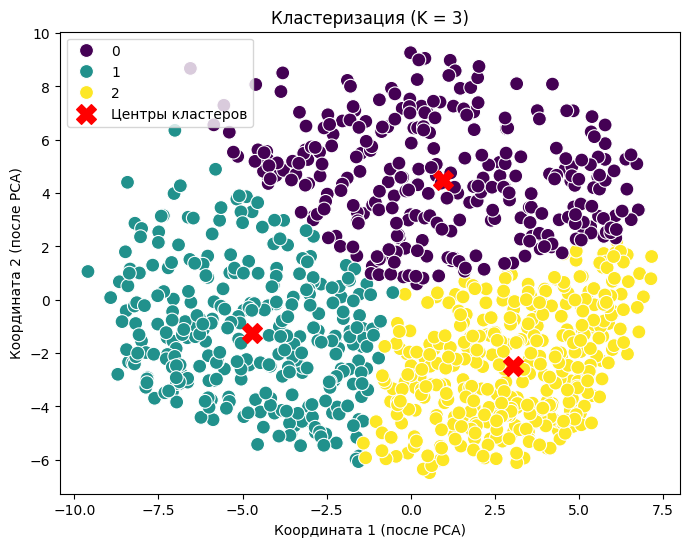

Коэффициент силуэта: 0.42


In [17]:
# Кластеризация с использованием KMeans
def cluster_and_visualize(features, n_clusters, labels=None):
  """
  Кластеризация данных и визуализация.

  features: np.ndarray - Признаки (N, D).
  n_clusters: int - Число кластеров.
  labels: np.ndarray - Истинные метки, если известны (для проверки).

  return: np.ndarray - Метки кластеров.
  """
  kmeans = KMeans(n_clusters=n_clusters, random_state=42)
  cluster_labels = kmeans.fit_predict(features)  # Кластеризация данных

  # Визуализация кластеров
  plt.figure(figsize=(8, 6))
  sns.scatterplot(x=features[:, 0], y=features[:, 1], hue=cluster_labels, palette="viridis", s=100)
  plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
              color="red", marker="X", s=200, label="Центры кластеров")
  plt.title(f"Кластеризация (K = {n_clusters})")
  plt.xlabel("Координата 1 (после PCA)")
  plt.ylabel("Координата 2 (после PCA)")
  plt.legend()
  plt.show()

  # Если истинные метки предоставлены
  if labels is not None:
    score = silhouette_score(features, cluster_labels)
    print(f"Коэффициент силуэта: {score:.2f}")

  return cluster_labels

# Выполняем кластеризацию для 3 групп
cluster_labels = cluster_and_visualize(reduced_features, n_clusters=3, labels=labels)


K = 2, Коэффициент силуэта = 0.38
K = 3, Коэффициент силуэта = 0.42
K = 4, Коэффициент силуэта = 0.41
K = 5, Коэффициент силуэта = 0.37
K = 6, Коэффициент силуэта = 0.36


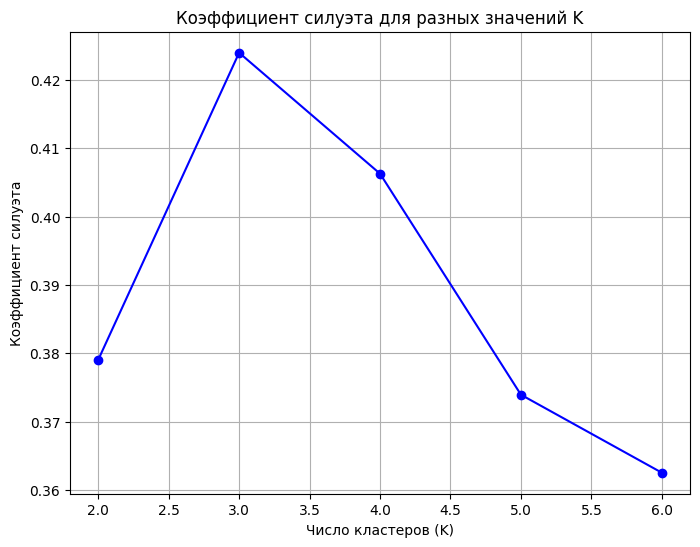

In [18]:
# Тестирование кластеризации с разным числом кластеров
def test_different_clusters(features, max_clusters=10):
  """
  Тестирование различных значений K для кластеризации KMeans.

  features: np.ndarray - Признаки (N, D).
  max_clusters: int - Максимальное число кластеров для тестирования.

  return: None
  """
  scores = []
  for k in range(2, max_clusters + 1):  # Перебираем значения K
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(features)
    score = silhouette_score(features, cluster_labels)  # Считаем коэффициент силуэта
    scores.append((k, score))
    print(f"K = {k}, Коэффициент силуэта = {score:.2f}")

  # Визуализация зависимости силуэта от K
  k_values, silhouette_scores = zip(*scores)
  plt.figure(figsize=(8, 6))
  plt.plot(k_values, silhouette_scores, marker="o", color="blue")
  plt.title("Коэффициент силуэта для разных значений K")
  plt.xlabel("Число кластеров (K)")
  plt.ylabel("Коэффициент силуэта")
  plt.grid(True)
  plt.show()

# Тестируем кластеризацию
test_different_clusters(reduced_features, max_clusters=6)


Кластер 0: Усреднённые признаки рассчитаны.
Кластер 1: Усреднённые признаки рассчитаны.
Кластер 2: Усреднённые признаки рассчитаны.


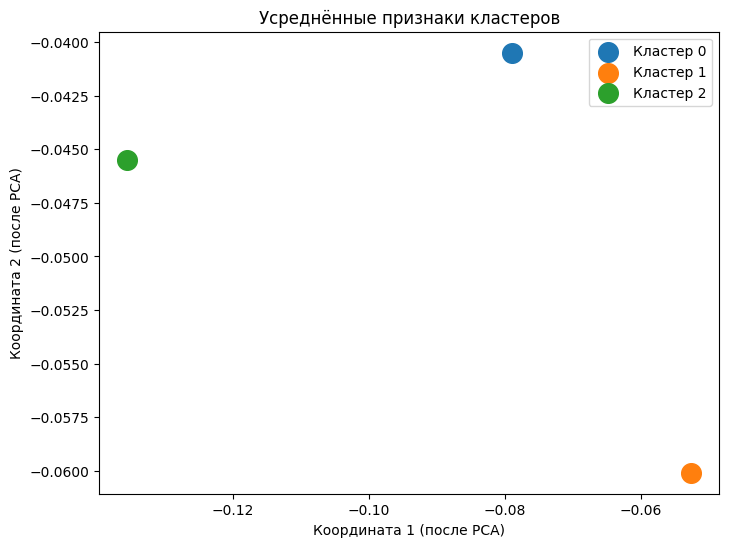

In [19]:
# Усреднение внутри кластеров
def compute_group_averages(features, cluster_labels):
  """
  Вычисление усреднённых признаков для каждого кластера.

  features: np.ndarray - Признаки (N, D).
  cluster_labels: np.ndarray - Метки кластеров (N,).

  return: dict - Средние признаки для каждого кластера.
  """
  unique_clusters = np.unique(cluster_labels)
  averages = {}
  for cluster in unique_clusters:
    cluster_features = features[cluster_labels == cluster]  # Признаки текущего кластера
    averages[cluster] = np.mean(cluster_features, axis=0)  # Средние значения
    print(f"Кластер {cluster}: Усреднённые признаки рассчитаны.")
  return averages

# Расчёт усреднённых признаков
cluster_averages = compute_group_averages(features, cluster_labels)

# Визуализация усреднённых признаков
plt.figure(figsize=(8, 6))
for cluster, avg in cluster_averages.items():
  plt.scatter(avg[0], avg[1], label=f"Кластер {cluster}", s=200, marker="o")
plt.title("Усреднённые признаки кластеров")
plt.xlabel("Координата 1 (после PCA)")
plt.ylabel("Координата 2 (после PCA)")
plt.legend()
plt.show()
